# Classifiez automatiquement des biens de consommation : 
*Notebook mission 2 - R√©alisez une classification supervis√©e d'images*

**Classification supervi√©e d‚Äôimages via CNN Transfer Learning**

Pourrais-tu r√©aliser une classification supervis√©e √† partir des images ? Je souhaiterais que tu mettes en place une data augmentation afin d‚Äôoptimiser le mod√®le?

In [2]:
# fonctions personnelles pour le pr√© traitement des donn√©es textuelles
import pre_treatment_text as ptt

import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm

import sklearn

# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

from sklearn.manifold import TSNE

import timeit
import time

from collections import defaultdict
from collections import Counter

import cv2

import os
from os import listdir

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

import shutil

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)

print("sklearn version", sklearn.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
sklearn version 1.6.1


## 1 - Pr√©paration du dataset

In [4]:
# Charger le fichier de donn√©es
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_6/data_projet/Dataset+projet+preÃÅtraitement+textes+images/Flipkart/flipkart_com-ecommerce_sample_1050.csv", \
                   sep=',', low_memory=False)
data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [5]:
# Appliquer la m√©thode split sur chaque √©l√©ment de la colonne
y = data['product_category_tree'].apply(lambda x: ptt.clean_category_first_level(x))
data['category'] = y

In [6]:
data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications         category  
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing  
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care  
2  {"product_specification"=>[{"key"=>"Material",...        Baby Care  
3  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing  
4  {"product_specification"=>[{"key"=>"Machine Wa...  Home Furnishing

## 2 - Cr√©ation des sous-dossiers par cat√©gorie

On va cr√©er un dossier pour les images d'entra√Ænement, et un dossier pour les images de tests.

In [8]:
path = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category"

In [9]:
# D√©finir les dossiers contenant les images
source_folder = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/Images/"  # Dossier o√π se trouvent les images
train_folder = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category"  # 75% des images
test_folder = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category_test"  # 25% des images

# S√©parer les donn√©es (75% train, 25% test)
df_train, df_test = train_test_split(data, test_size=0.25, stratify=data['category'], random_state=42)

def copy_images(df_subset, destination_folder):
    """ Fonction pour copier les images dans le dossier appropri√©. """
    for _, row in df_subset.iterrows():
        image_name = row['image']
        category = row['category']

        # Chemin source et destination
        src_path = os.path.join(source_folder, image_name)
        dest_folder = os.path.join(destination_folder, category)
        dest_path = os.path.join(dest_folder, image_name)

        # Cr√©er le dossier s'il n'existe pas
        os.makedirs(dest_folder, exist_ok=True)

        # V√©rifier si l'image existe avant de la copier
        if os.path.exists(src_path):
            shutil.copy2(src_path, dest_path)  # Copie sans supprimer l'original
            print(f"‚úÖ {image_name} copi√© dans {dest_folder}")
        else:
            print(f"‚ö†Ô∏è Image non trouv√©e : {image_name}")

# Copier les images dans les dossiers appropri√©s
print("üìÇ Copie des images d'entra√Ænement...")
copy_images(df_train, train_folder)

print("üìÇ Copie des images de test...")
copy_images(df_test, test_folder)

print("‚úÖ Op√©ration termin√©e (75% entra√Ænement, 25% test) !")

üìÇ Copie des images d'entra√Ænement...
‚úÖ 96bc1fbb83ad5a2c0441d132fe8bcf97.jpg copi√© dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Baby Care
‚úÖ 22ac36ba254a68d7dd6173f099771147.jpg copi√© dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Baby Care
‚úÖ 7915f1c0703450d4b1446c06066d9a59.jpg copi√© dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Home Furnishing
‚úÖ 90906358dac904c4f05c12c798ac5221.jpg copi√© dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Home Furnishing
‚úÖ 95cb9561009bd6707c67f05e6a00c16e.jpg copi√© dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Home Decor  Festive Needs
‚úÖ d1e18b4a3aafb0040da2111c8b8ce2e5.jpg copi√© dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Home Decor  Festive Needs
‚úÖ 87f256eeace1a0c2b1f934f061646da5.jp

## 3 - Cr√©ation du mod√®le de classification

- Charge le mod√®le pr√©-entra√Æn√© VGG16
  
  + include_top=False : Supprime les couches de classification de VGG16.
  + weights="imagenet" : Charge les poids pr√©-entra√Æn√©s sur ImageNet.
  + input_shape=(224, 224, 3) : D√©finit l‚Äôentr√©e du r√©seau pour des images couleur de 224√ó224 pixels.

- G√®le les couches du mod√®le pr√©-entra√Æn√©

  + Emp√™che la modification des poids de VGG16 pendant l'entra√Ænement.
  + Seules les couches ajout√©es seront entra√Æn√©es.

- Ajoute des couches suppl√©mentaires

  + GlobalAveragePooling2D : R√©duit la dimension de sortie sans trop de param√®tres.
  + Dense(256, activation='relu') : Ajoute une couche enti√®rement connect√©e.
  + Dropout(0.5) : R√©duit le risque d'overfitting en d√©sactivant 50% des neurones.
  + Dense(4, activation='softmax') : La derni√®re couche de classification avec 7 classes.

- Cr√©e et compile le mod√®le

  + D√©finit le mod√®le final avec comme entr√©e VGG16 et comme sortie la nouvelle couche de classification.
  + Compile le mod√®le

In [11]:
def create_model_fct() :
    # R√©cup√©ration mod√®le pr√©-entra√Æn√©
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entra√Ænables = on garde les poids du mod√®le pr√©-entra√Æn√©
    for layer in model0.layers:
        layer.trainable = False

    # R√©cup√©rer la sortie de ce r√©seau
    x = model0.output
    # Compl√©ter le mod√®le
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # D√©finir le nouveau mod√®le
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du mod√®le
    # loss="categorical_crossentropy" ‚Üí Adapt√© pour un probl√®me de classification multi-classes.
    # optimizer='rmsprop' ‚Üí Optimiseur recommand√© pour le fine-tuning.
    # metrics=["accuracy"] ‚Üí Suit la pr√©cision du mod√®le.
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

## 4 - Approche nouvelle par Dataset avec data augmentation int√©gr√©e au mod√®le

L‚Äôapproche nouvelle par dataset avec data augmentation int√©gr√©e au mod√®le d√©signe une m√©thode dans laquelle l'augmentation des donn√©es (data augmentation) est effectu√©e directement dans le pipeline du mod√®le, plut√¥t que d‚Äô√™tre r√©alis√©e en amont (par pr√©traitement des images).

- Data Augmentation = technique permettant d‚Äôaugmenter artificiellement la taille et la diversit√© d‚Äôun dataset en appliquant des transformations (rotation, zoom, bruit, etc.) sur les images d‚Äôentra√Ænement. Cela am√©liore la g√©n√©ralisation du mod√®le et r√©duit le surapprentissage (overfitting).

- Int√©gr√©e au Mod√®le = l‚Äôaugmentation des donn√©es n‚Äôest pas faite en pr√©traitement (offline) mais au moment de l'entra√Ænement, via des couches sp√©cifiques ou un pipeline de traitement dynamique.

Avantages :
- Gain de temps : Pas besoin de stocker un grand volume de donn√©es augment√©es.
- Flexibilit√© : Les transformations sont appliqu√©es diff√©remment √† chaque √©poque d'entra√Ænement.
- Optimisation m√©moire : Les images sont augment√©es √† la vol√©e, ce qui √©vite de stocker une grande base de donn√©es augment√©e.

**fonction pour charger un dataset d'images** √† partir d'un r√©pertoire en utilisant image_dataset_from_directory de TensorFlow/Keras.

- path : Sp√©cifie le chemin du dataset.
- labels='inferred' : TensorFlow d√©tecte automatiquement les labels en fonction des noms de dossiers.
- label_mode='categorical' : Les labels sont encod√©s sous forme one-hot (ex. [0, 1, 0, 0] pour une classe parmi 4).
- class_names=None : Les noms des classes sont d√©tect√©s automatiquement.
- batch_size=batch_size : D√©finit la taille des mini-batches.
- image_size=(224, 224) : Redimensionne les images en 224√ó224 pixels (exig√© par VGG16).
- shuffle=True : M√©lange les images pour am√©liorer la g√©n√©ralisation.
- seed=42 : Assure une r√©partition reproductible des donn√©es.
- validation_split=validation_split : Si non nul, s√©pare une partie du dataset pour la validation.
- subset=data_type : Sp√©cifie si on charge le dataset d'entra√Ænement ("training") ou de validation ("validation").

In [14]:
batch_size = 32
path = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category"
path_test = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category_test"

In [15]:
def dataset_fct(path, validation_split=0, data_type=None) :
    """
        path : Chemin du dossier contenant les images organis√©es en sous-dossiers par classe.
        validation_split : Pourcentage du dataset √† utiliser pour la validation (ex. 0.2 pour 20%).
        data_type : D√©termine si on charge les donn√©es d'entra√Ænement ("training") ou de validation ("validation").
    """

    #  Cr√©ation du dataset
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

**Cr√©ons les dataset d'entrainement, de validation et de test**

In [17]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 787 files belonging to 7 classes.
Using 591 files for training.
Found 787 files belonging to 7 classes.
Using 196 files for validation.
Found 263 files belonging to 7 classes.


**Cr√©ons une fonction de normalisation de l'image**

- Conversion et redimensionnement de l‚Äôimage
- Normalisation des pixels

In [19]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)   # Convertit l‚Äôimage en type float32 pour √©viter des probl√®mes de format
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])   # Redimensionne l‚Äôimage aux dimensions IMG_SIZE x IMG_SIZE (ex : 224x224 pour VGG16).
    image = (image / 255.0)   # pr√©traitement standard pour les r√©seaux de neurones
    return image, label

**Cr√©ons une fonction pour calculer la m√©trique AUC**

In [21]:
#import tensorflow as tf
#import keras.backend as K

#def auc(y_true, y_pred):
#    return tf.numpy_function(tf.keras.metrics.AUC(), [y_true, y_pred], tf.float32)

**Cr√©ons la fonction de cr√©ation du mod√®le de deep learning ave VGG16**

- Augmentation de donn√©es
- R√©cup√©ration du mod√®le pr√©-entra√Æn√© VGG16
- D√©finition du mod√®le final cr√©√© avec un Sequential
- Compilation du mod√®le

In [23]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),   # Effectue un retournement horizontal al√©atoire de l'image
        RandomRotation(0.1),    # Effectue une rotation al√©atoire des images dans une plage de -10% √† +10% de l'angle
        RandomZoom(0.1),   # Applique un zoom al√©atoire avec une amplitude de 10%
      ])
    
    # R√©cup√©ration mod√®le pr√©-entra√Æn√©
    #include_top=False : retirer la derni√®re couche enti√®rement connect√©e 
    #weights="imagenet" : Utilise les poids pr√©-entra√Æn√©s sur ImageNet.
    #input_shape=(224, 224, 3) : Sp√©cifie la taille des images d'entr√©e (ici 224x224 pixels, avec 3 canaux de couleur).
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # D√©finition du nouveau mod√®le
    model = Sequential([
                data_augmentation,  # Les images passent d'abord par les √©tapes d'augmentation de donn√©es
                Rescaling(1./127.5, offset=-1),   # Les pixels de l'image sont mis √† l'√©chelle
                model_base,    # La partie pr√©-entra√Æn√©e du mod√®le VGG16
                GlobalAveragePooling2D(),  # Cette couche r√©duit la sortie de VGG16 en un vecteur de caract√©ristiques de taille fixe
                Dense(256, activation='relu'),   # Une couche dense avec 256 neurones et une fonction d'activation ReLU
                Dropout(0.5),   # Une couche de dropout pour r√©duire le surapprentissage
                Dense(7, activation='softmax')    # La couche de sortie avec 7 neurones + a fonction d'activation softmax produit des probabilit√©s pour chaque classe
                ])

    # compilation du mod√®le 
    # categorical_crossentropy : Une fonction de perte utilis√©e pour les probl√®mes de classification multi-classes.
    # optimizer='adam' : L'optimiseur Adam est utilis√©, car il est robuste et efficace pour la plupart des probl√®mes.
    # metrics=["accuracy"] : La m√©trique utilis√©e pour √©valuer les performances du mod√®le est la pr√©cision.    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])

    print(model.summary())
    
    return model

- Cr√©ation du mod√®le sur le GPU
- Cr√©ation d'un Callback pour sauvegarder le meilleur mod√®le
- Cr√©ation d'un Callback pour arr√™ter l'entra√Ænement si n√©cessaire
- Regroupement des Callbacks

In [25]:
# D√©tection automatique du GPU ou utilisation du CPU
device = "/gpu:0" if tf.config.list_physical_devices('GPU') else "/cpu:0"

# Cr√©ation du mod√®le
with tf.device(device): 
    model1 = create_model_fct2()

# Cr√©ation du callback
model1_save_path = "./model1_best_weights.keras" 

checkpoint = ModelCheckpoint(model1_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks_list = [checkpoint, es]

C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ sequential (Sequential)         ‚îÇ (None, 224, 224, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ rescaling (Rescaling)           ‚îÇ (None, 224, 224, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ vgg16 (Functional)              ‚îÇ (None, 7, 7, 512)      ‚îÇ    14,714,688 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d        ‚îÇ (None, 512)            ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 256)            ‚îÇ       131,328 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 7)              ‚îÇ         1,799 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [26]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Normal car je n'ai pas de GPU install√©, j'ai utilis√© la CPU.

**Entra√Ænons un mod√®le**

- D√©tection du p√©riph√©rique
- Entra√Ænement du mod√®le
- Enregistrer les performances

In [28]:
# V√©rifier si un GPU est disponible
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'

with tf.device(device): 
    history1 = model1.fit(dataset_train,
                          validation_data=dataset_val,
                          batch_size=batch_size, epochs=50, # Le nombre d'√©poques d'entra√Ænement : 50 fois.
                          callbacks=callbacks_list, # liste de rappels (callbacks) utilis√©s pendant l'entra√Ænement pour ex√©cuter certaines actions
                          verbose=1)

Epoch 1/50
19/19 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6s/step - accuracy: 0.2418 - auc: 0.5961 - loss: 1.9600
Epoch 1: val_loss improved from inf to 1.42465, saving model to ./model1_best_weights.keras
19/19 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 169s 9s/step - accuracy: 0.2436 - auc: 0.5990 - loss: 1.9540 - val_accuracy: 0.6071 - val_auc: 0.8879 - val_loss: 1.4246
Epoch 2/50
19/19 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8s/step - accuracy: 0.4646 - auc: 0.8068 - loss: 1.5099
Epoch 2: val_loss improved from 1.42465 to 1.10434, saving model to ./model1_best_weights.keras
19/19 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 191s 10s/step - accuracy: 0.4670 - auc: 0.8077 - loss: 1.5072 - val_accuracy: 0.6990 - val_auc: 0.9338 - val_loss: 1.1043
Epoch 3/50
19/19 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8s/step - accuracy: 0.6034 - auc: 0.8924 - loss: 1.2259
Epoch 3: val_loss improv

**Evaluons la performance du mod√®le**

- Charger les poids du mod√®le
- Evaluation du mod√®le sur le jeu de validation
- √âvaluation du mod√®le sur le jeu de test

Interpr√©tation de l'accuracy: l'accuracy est toujours une valeur entre 0 et 1

- 0 : Le mod√®le a fait des pr√©dictions incorrectes pour toutes les donn√©es.
- 1 : Le mod√®le a fait des pr√©dictions correctes pour toutes les donn√©es.

In [31]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path)

# loss, accuracy : Ce sont les deux valeurs retourn√©es par la m√©thode evaluate(). 
# La premi√®re est la perte (une mesure de l'erreur du mod√®le) et
# la seconde est la pr√©cision (le pourcentage de pr√©dictions correctes).
loss, accuracy, auc = model1.evaluate(dataset_val, verbose=False)
print(f"Validation Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

loss, accuracy, auc = model1.evaluate(dataset_test, verbose=False)
print(f"Test Accuracy      : {accuracy:.4f}, AUC: {auc:.4f}")

Validation Accuracy: 0.7755, AUC: 0.9643
Test Accuracy      : 0.7947, AUC: 0.9646


**Affichons les courbes**

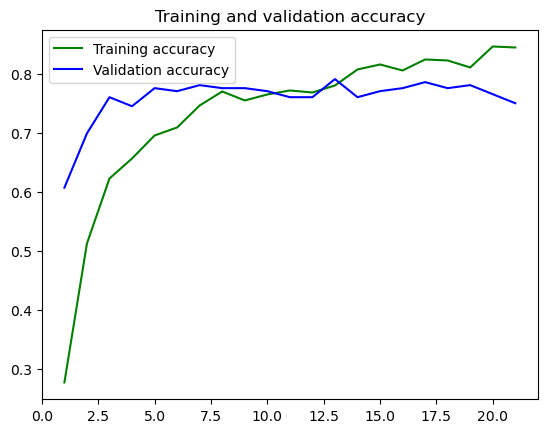

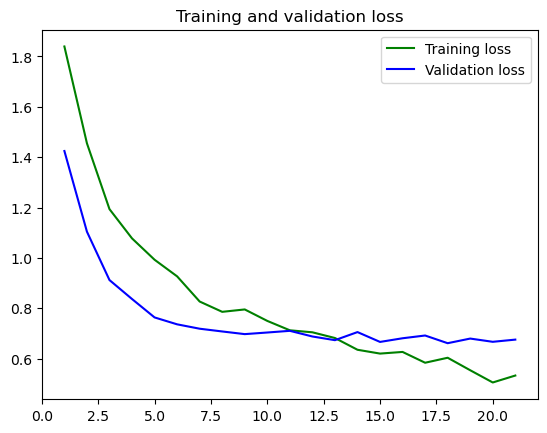

<Figure size 640x480 with 0 Axes>

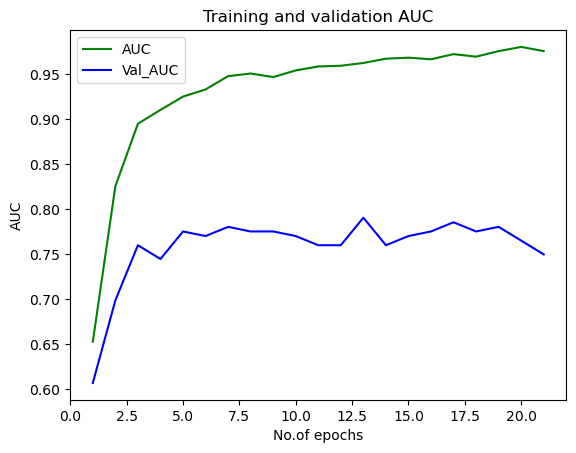

<Figure size 640x480 with 0 Axes>

In [35]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
AUC = history1.history['auc']
val_AUC = history1.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, AUC, 'g', label='AUC')
plt.plot(epochs, val_AUC, 'b', label='Val_AUC')
plt.xlabel('No.of epochs')
plt.ylabel('AUC')
plt.title('Training and validation AUC')
plt.legend()
plt.figure()